### **Wind Power Generation Forecasting Using Transformer-based Time Series Models**


Supervisor: Jenny Alexandra Cifuentes Quintero \\
Author: Teresa Oriol Guerra


**PREDICTION GRAPH FOR BEST TRANSFORMER**

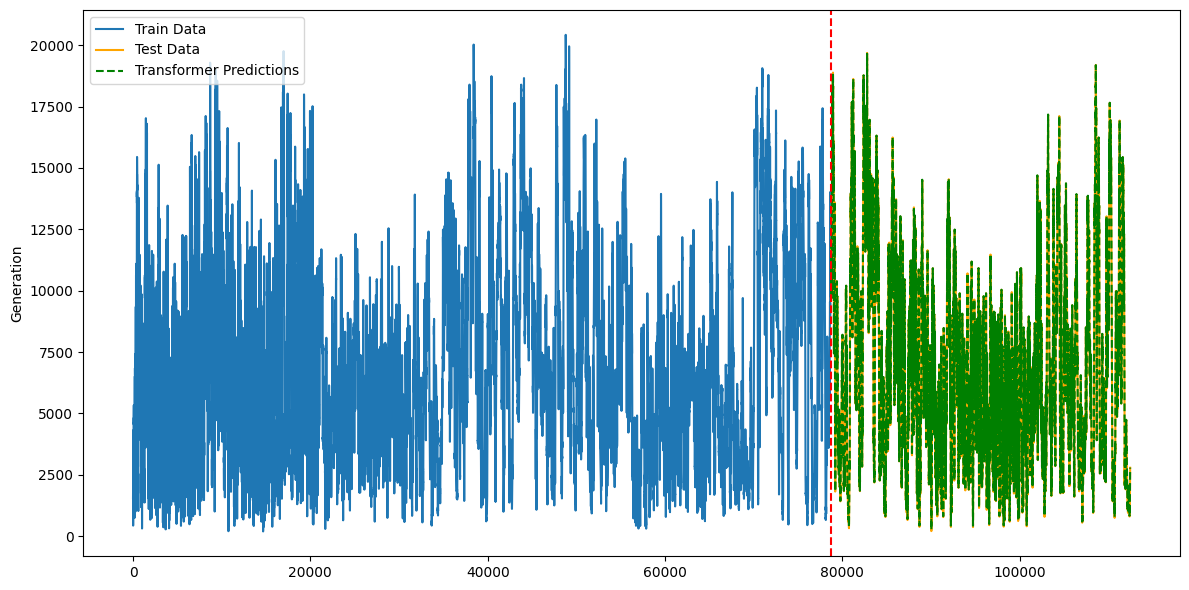

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Leer datos
df = pd.read_excel("df_final.xlsx")
data = df[['Generation']].dropna().values
mean, std = data.mean(), data.std()
data_normalized = (data - mean) / std
tensor_data = torch.tensor(data_normalized, dtype=torch.float32)

# Separar en train/test
train_size = int(0.7 * len(tensor_data))
train_data, test_data = tensor_data[:train_size], tensor_data[train_size:]

# Crear secuencias
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq_input = data[i:i+seq_length]
        seq_target = data[i+1:i+seq_length+1]
        sequences.append((seq_input, seq_target))
    return sequences

seq_length = 12
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

train_loader = DataLoader(train_sequences, batch_size=16, shuffle=True)
test_loader = DataLoader(test_sequences, batch_size=16, shuffle=False)

# Modelo Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(model_dim, input_dim)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        output = self.transformer(src, tgt)
        return self.fc_out(output)

# Entrenar el modelo
model = TransformerModel(1, 32, 4, 3, 0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):  # puedes subir este número
    model.train()
    for src, tgt in train_loader:
        optimizer.zero_grad()
        output = model(src, tgt)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

# Obtener predicciones
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for src, tgt in test_loader:
        output = model(src, tgt)
        predictions.append(output[:, -1].squeeze().numpy())
        actuals.append(tgt[:, -1].squeeze().numpy())

y_pred = np.concatenate(predictions)
y_test = np.concatenate(actuals)

# Denormalizar
y_pred_denorm = (y_pred * std) + mean
y_test_denorm = (y_test * std) + mean

# Crear ejes completos de Train + Test
full_data = data.flatten()
train_plot = full_data[:train_size]
test_plot = full_data[train_size + seq_length:]  # compensar la secuencia

# Insertar predicciones al mismo tamaño que test_plot
pred_plot = np.empty_like(test_plot)
pred_plot[:] = np.nan
pred_plot[:len(y_pred_denorm)] = y_pred_denorm

# Graficar
plt.figure(figsize=(12,6))
plt.plot(train_plot, label="Train Data")
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(test_plot)), test_plot, label="Test Data", color='orange')
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(pred_plot)), pred_plot, label="Transformer Predictions", linestyle='--', color='green')
plt.axvline(x=train_size, color='red', linestyle='--')
plt.ylabel("Generation")
plt.legend()
plt.tight_layout()
plt.show()

PLOT WITH ZOOM FROM NOVEMBER 2023

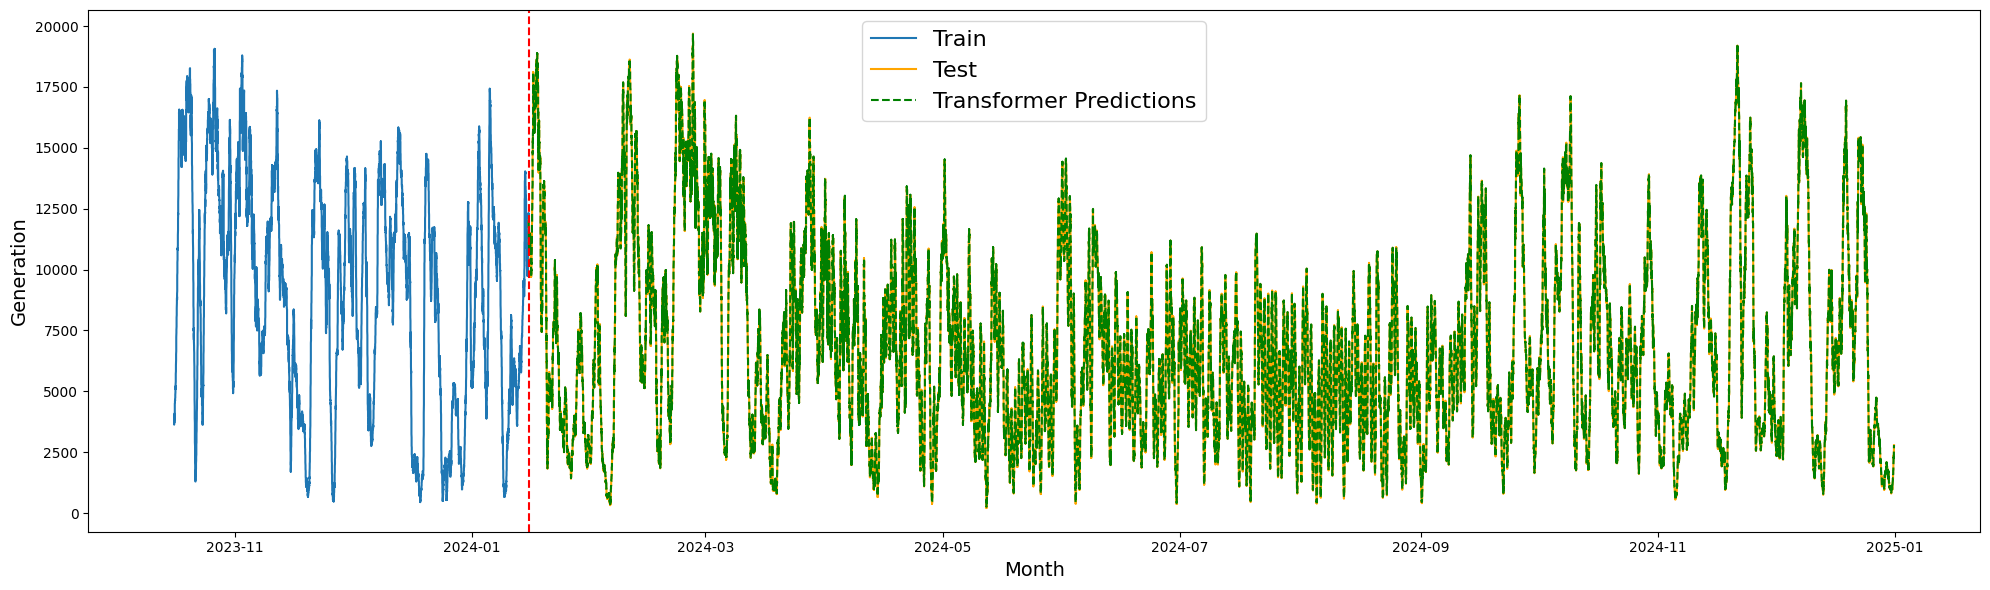

In [21]:
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'])

# Obtener el índice donde comienzan las predicciones (inicio del test set)
pred_start_idx = train_size + seq_length

# Mostrar 1 año antes del inicio de las predicciones (8760 pasos horarios)
zoom_offset = 8760  # 365 días * 24 horas
zoom_start_idx = pred_start_idx - zoom_offset

# Preparar rango temporal para eje x
fechas = df['Fecha y Hora'].values
x_train = fechas[zoom_start_idx:pred_start_idx]
x_test = fechas[pred_start_idx:pred_start_idx + len(test_plot)]

plt.figure(figsize=(20,6))
plt.plot(x_train, data[zoom_start_idx:pred_start_idx], label="Train")
plt.plot(x_test, test_plot, label="Test", color='orange')
plt.plot(x_test, pred_plot, label="Transformer Predictions", linestyle='--', color='green')
plt.axvline(x=fechas[pred_start_idx], color='red', linestyle='--')
plt.ylabel("Generation", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()
